In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from sgnNet import SGN
from dataset import Seq2PointWindows
from training import train_one_epoch, evaluate_mae, main_train
from inference import infer_seq2point_timeline

from refit_dataloader import load_house_csv


In [ ]:
DATAPATH = r"C:\\Users\\rcper\DSM-Research\Simple-disaggregation\SGNCode\\CLEAN_REFIT_081116\\CLEAN_House2.csv"
APPLIANCE_COL = "Appliance2"
MAX_MINUTES = 500000 
WIN_LEN = 64
STRIDE = 32
BATCH_SIZE = 32
EPOCHS = 100
LR = 1e-3
BACKBONE_KIND = "tcn"
PATIENCE = 5
MIN_DELTA = 0.0


In [3]:
mains, target, ts = load_house_csv(DATAPATH, appliance_col=APPLIANCE_COL, max_minutes = MAX_MINUTES)
print(f"Loaded {len(mains)} samples for House 2")

Loaded 500000 samples for House 2


In [4]:
n = len(mains)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

mains_train, target_train = mains[:train_end], target[:train_end]
mains_val, target_val = mains[train_end:val_end], target[train_end:val_end]
mains_test, target_test   = mains[val_end:], target[val_end:]

train_ds = Seq2PointWindows(mains_train, target_train, win_len=WIN_LEN, stride=STRIDE, train=True)
val_ds   = Seq2PointWindows(mains_val, target_val, win_len=WIN_LEN, stride=STRIDE, train=False)
test_ds  = Seq2PointWindows(mains_test, target_test, win_len=WIN_LEN, stride=STRIDE, train=False)


Epoch 001 | Train Loss (scaled): 0.5687 | Val MAE (W): 27.6889
Epoch 002 | Train Loss (scaled): 0.4230 | Val MAE (W): 21.4421
Epoch 003 | Train Loss (scaled): 0.4098 | Val MAE (W): 22.0053
Epoch 004 | Train Loss (scaled): 0.3800 | Val MAE (W): 21.0856
Epoch 005 | Train Loss (scaled): 0.3544 | Val MAE (W): 21.2868
Epoch 006 | Train Loss (scaled): 0.3512 | Val MAE (W): 20.4791
Epoch 007 | Train Loss (scaled): 0.3428 | Val MAE (W): 20.7847
Epoch 008 | Train Loss (scaled): 0.3322 | Val MAE (W): 22.6056
Epoch 009 | Train Loss (scaled): 0.3253 | Val MAE (W): 17.3021
Epoch 010 | Train Loss (scaled): 0.3195 | Val MAE (W): 16.7408
Epoch 011 | Train Loss (scaled): 0.3063 | Val MAE (W): 16.2675
Epoch 012 | Train Loss (scaled): 0.3114 | Val MAE (W): 17.8952
Epoch 013 | Train Loss (scaled): 0.3197 | Val MAE (W): 16.7853
Epoch 014 | Train Loss (scaled): 0.3076 | Val MAE (W): 17.1871
Epoch 015 | Train Loss (scaled): 0.2745 | Val MAE (W): 15.4908
Epoch 016 | Train Loss (scaled): 0.2703 | Val MAE (W): 

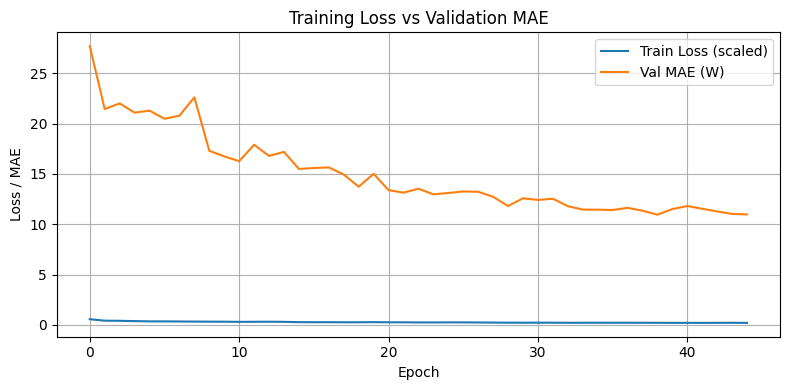

{'train_losses': [0.5687396466813788,
  0.42296867889522904,
  0.4097627883530884,
  0.3799974831806561,
  0.35442091737318976,
  0.3512271844256017,
  0.34281534828112775,
  0.3322044577727211,
  0.32528414399208516,
  0.3195129602098225,
  0.30633343936212,
  0.31140684948482084,
  0.31972205273681,
  0.30759427526741745,
  0.27446533906497966,
  0.27034575190236704,
  0.2729390437165842,
  0.2622247471240322,
  0.26512524945364185,
  0.275765870159273,
  0.26327513647668155,
  0.2589871303207753,
  0.24705102173334723,
  0.24585578427447757,
  0.25425469696549013,
  0.25161266133945503,
  0.24436136787756427,
  0.23359418118114497,
  0.22405054304334854,
  0.21975263467813988,
  0.2239262471201216,
  0.22032605146347903,
  0.2121262791607006,
  0.21533777059678025,
  0.22084481528648023,
  0.21578173491308336,
  0.21778458767303552,
  0.21480876114687855,
  0.2120630672984217,
  0.20489655940784512,
  0.20735277634643778,
  0.20321669001856185,
  0.21075539413957112,
  0.21340526992

In [ ]:
results = main_train(
    mains_train, target_train,
    mains_val, target_val,
    win_len=WIN_LEN, batch_size=BATCH_SIZE, lr=LR, epochs=EPOCHS, kind=BACKBONE_KIND,
    patience=PATIENCE, min_delta=MIN_DELTA
)


In [6]:
ckpt = torch.load("sgn_best.pt", map_location="cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SGN(in_ch=1, hid=64, kind="tcn", out_len=1).to(device)
model.load_state_dict(ckpt["model"])
stats = ckpt["stats"]

y_pred = infer_seq2point_timeline(model, mains_test, stats, device)  # watts
y_true = target_test                                                  # watts


In [7]:
def smape(a, f):
    denom = (np.abs(a) + np.abs(f)).clip(1e-6, None)
    return (100.0 / len(a)) * np.sum(np.abs(f - a) / denom)

mae_w = np.mean(np.abs(y_pred - y_true))
energy_true = y_true.sum()
energy_pred = y_pred.sum()
sae = np.abs(energy_pred - energy_true) / (energy_true + 1e-6)
smape_val = smape(y_true, y_pred)

print(f"House2 {APPLIANCE_COL} | Test MAE (W): {mae_w:.2f}")
print(f"SAE (energy rel. error): {sae:.4f}")
print(f"sMAPE (%): {smape_val:.2f}")


House2 Appliance1 | Test MAE (W): 8.79
SAE (energy rel. error): 0.0845
sMAPE (%): 54.35


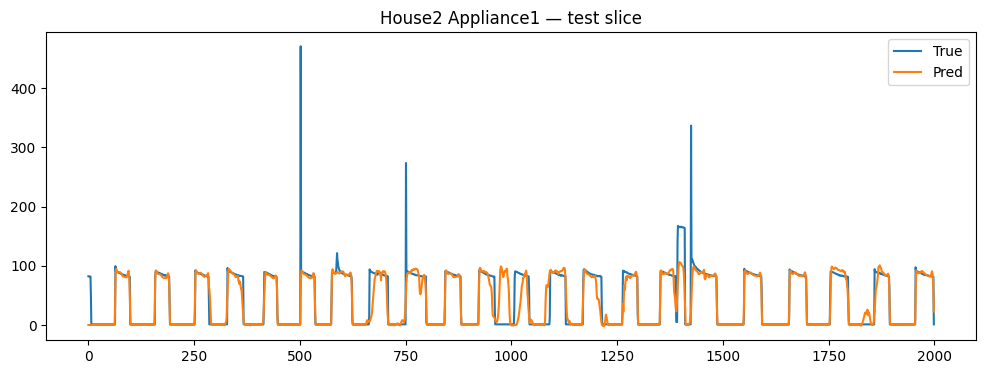

In [9]:
N = min(2000, len(y_true))
plt.figure(figsize=(12,4))
plt.plot(y_true[:N], label="True")
plt.plot(y_pred[:N], label="Pred")
plt.legend(); plt.title(f"House2 {APPLIANCE_COL} — test slice"); plt.show()
